In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import warnings
warnings.filterwarnings('ignore')
import sys
import plotly.express as px

In [2]:
pd.set_option('display.max_columns',10000)
pd.set_option('display.max_rows',10000)
np.set_printoptions(threshold=sys.maxsize)

In [298]:
df=pd.read_csv('smart_phone.csv')

In [299]:
df.head(2)

,Unnamed: 0,Name,Model_series,Rating,Spec_score,Dual Sim,VoLTE,5G,Vo5G,Ram,Battery,Display,Foldable Display,Dual Display,External_Memory,Android_version,Price,company,Inbuilt_memory,fast_charging,Water Drop Notch,with Punch Hole,H px,V px,Processor_,Processor_series,No _of_Rear,No _of_Front,Primary_rear_camera,Primary_front_camera,Number_of_core
0,0,Samsung Galaxy F14 5G,F,4.65,68,1,1,1,0,4.0,6000,6.6,0,0,1024.0,13.0,9999,samsung,128.0,25.0,1,0,2408,1080,exynos,1330.0,2,1,50.0,13.0,8
1,1,Samsung Galaxy A11,A,4.20,63,1,1,0,0,2.0,4000,6.4,0,0,512.0,10.0,9990,samsung,32.0,15.0,0,1,720,1560,snapdragon,450.0,3,1,13.0,8.0,8


In [300]:
df=df.drop(columns = ['Unnamed: 0'],axis='columns')
df.drop(['Android_version','Name','Rating','Spec_score','Dual Sim','Water Drop Notch','with Punch Hole'],axis=1,inplace=True)
df['Processor_']=df['Processor_'].replace('sc9863a','unisoc')
df=df[~df.Processor_.isin(['octa','other'])]

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 0 to 1369
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model_series          1364 non-null   object 
 1   VoLTE                 1364 non-null   int64  
 2   5G                    1364 non-null   int64  
 3   Vo5G                  1364 non-null   int64  
 4   Ram                   1364 non-null   float64
 5   Battery               1364 non-null   int64  
 6   Display               1364 non-null   float64
 7   Foldable Display      1364 non-null   int64  
 8   Dual Display          1364 non-null   int64  
 9   External_Memory       903 non-null    float64
 10  Price                 1364 non-null   int64  
 11  company               1364 non-null   object 
 12  Inbuilt_memory        1346 non-null   float64
 13  fast_charging         1280 non-null   float64
 14  H px                  1364 non-null   int64  
 15  V px                  1364

### missing value in inbuilt memory and fast charging and processor series

In [302]:
#removing outliear
df=df[df.Price<200000]
df=df[df.Battery<7000]

In [303]:
df.External_Memory.fillna(0,inplace=True)
fast_c=df.groupby('company')['fast_charging'].agg(lambda x: stats.mode(x)).apply(lambda x : x[0]).to_dict()
for i in fast_c:
    df.loc[df.company==i,'fast_charging']=df.loc[df.company==i,'fast_charging'].fillna(fast_c[i])
df=df.dropna()

In [304]:
# convert small company in other
temp=df.company.value_counts().reset_index()
l=temp[temp['count']<15]['company'].to_list()
df.company.replace(l,'other',inplace=True)

In [305]:
# add new column  PPI
df['PPI']=round(np.sqrt(df['V px']**2+df['H px']**2)/df.Display)
df=df.drop(['V px','H px','Display'],axis=1)

In [306]:
col=df.columns.to_list()
n_col=['Battery','Price','fast_charging','Primary_rear_camera','Primary_front_camera','PPI']
for r in n_col:
    col.remove(r)

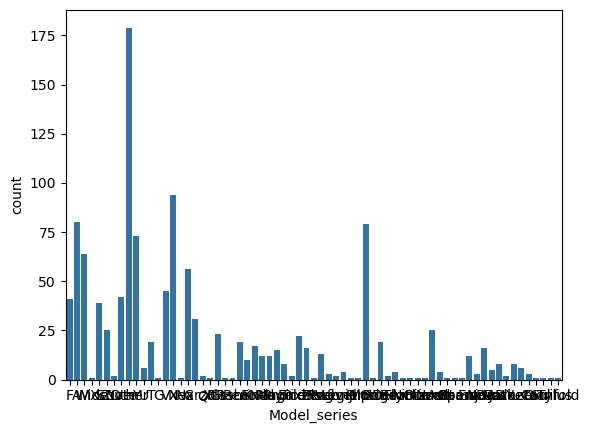

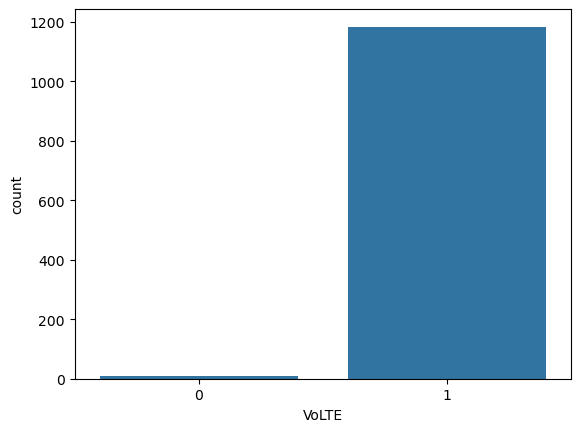

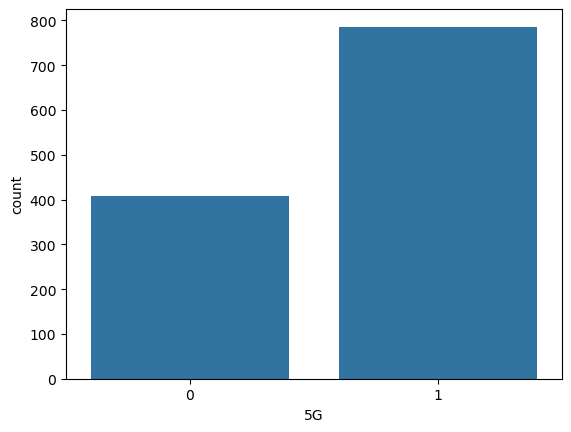

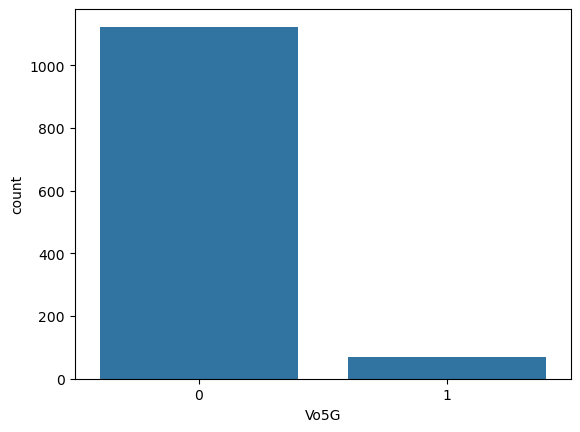

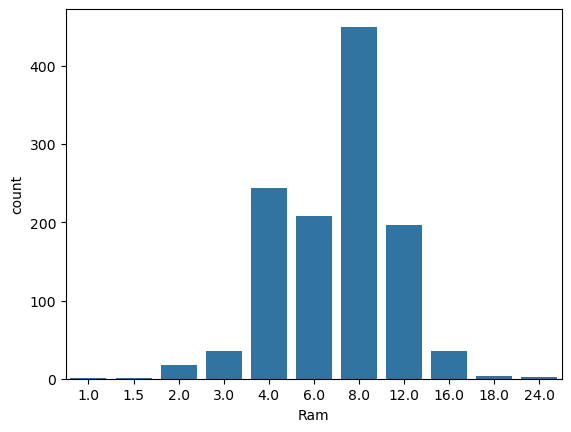

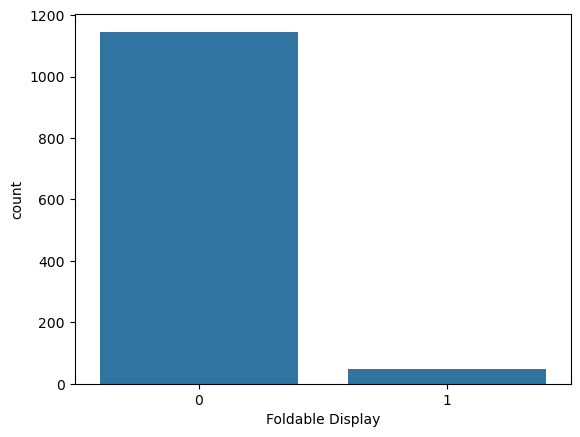

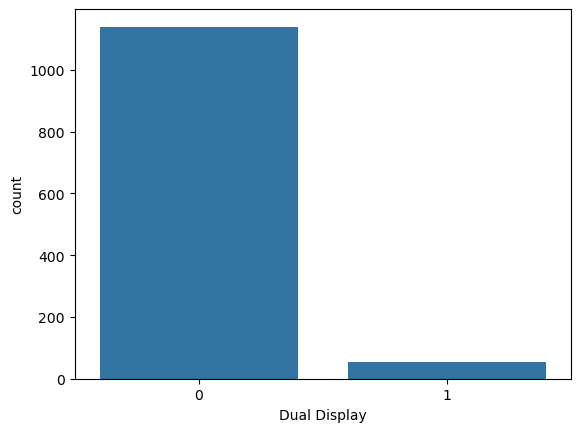

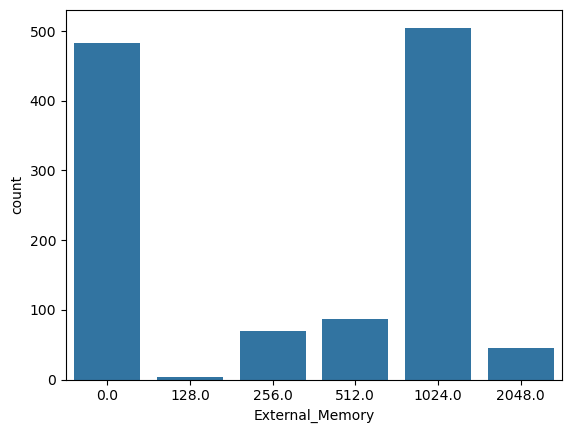

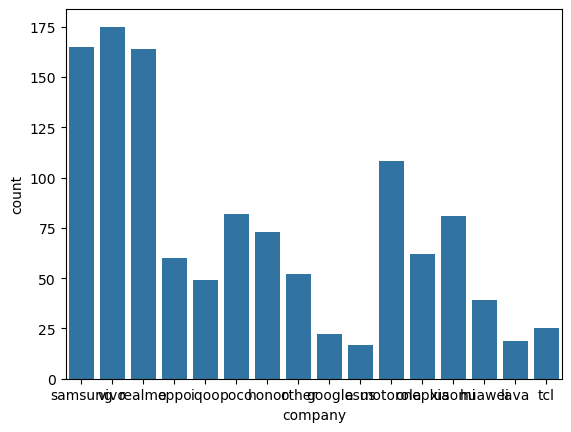

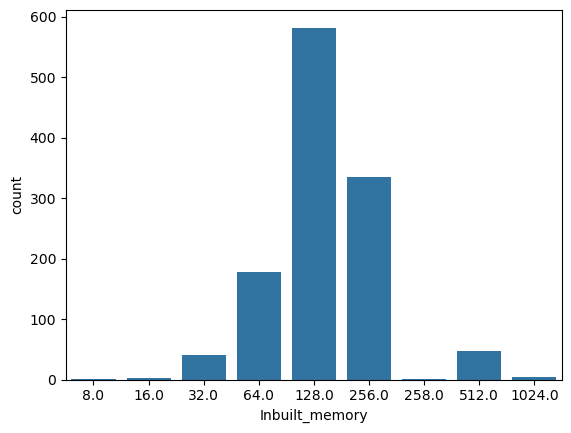

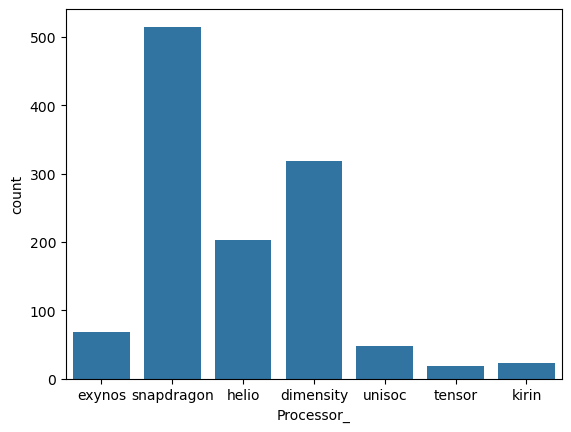

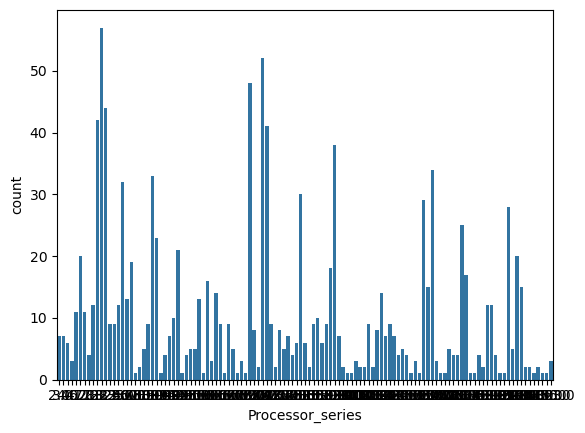

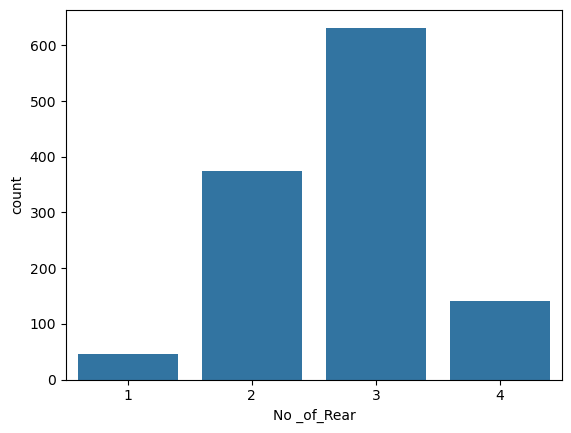

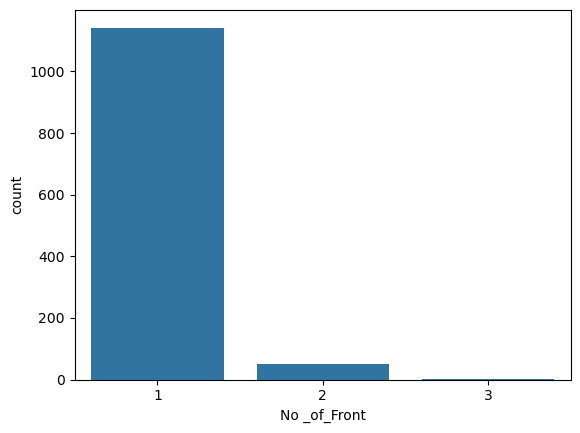

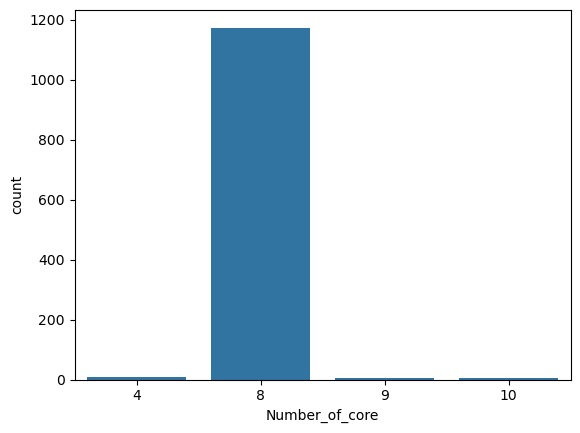

In [307]:
for i in col:
    sns.countplot(df,x=i)
    plt.show()
# Most of phones have dual sim
# all most have volte
# 70 % phone has 5g
# 5 % phone has vo5g
# Most of having 8 GB ram
# Most of phones have 128 GB and 256 GB
# 50% comes with sanpdragon
# 60% of phones have triple rear camera 
# 80% of phones come with a single front camera
# Processers come with 8-core

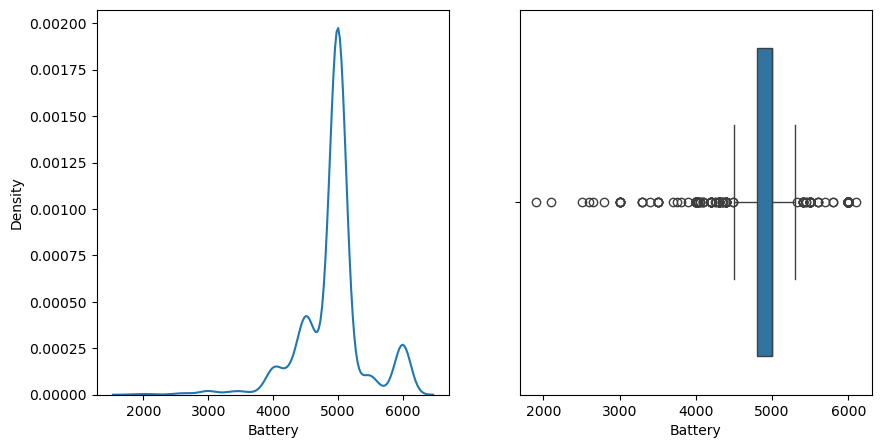

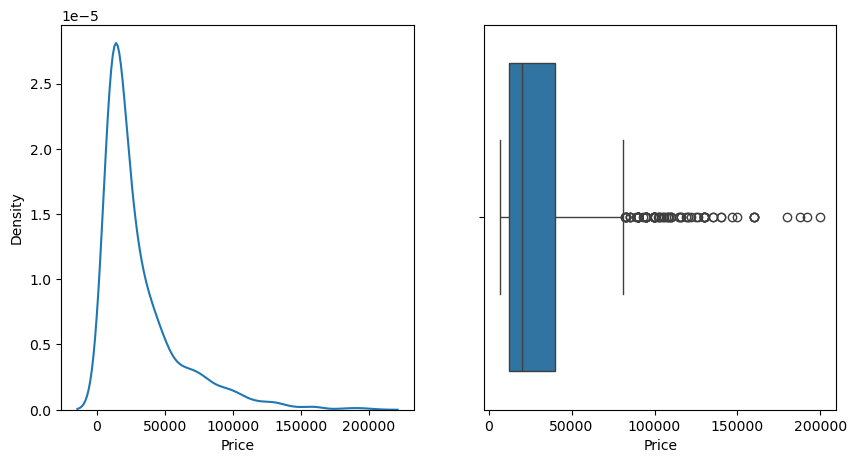

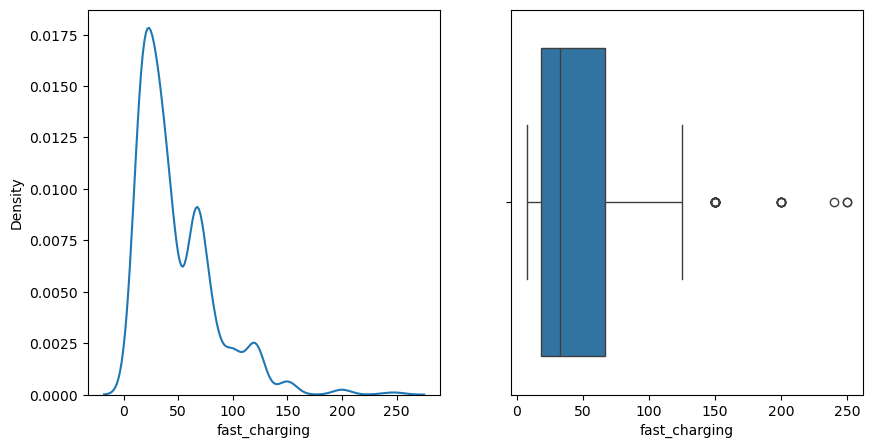

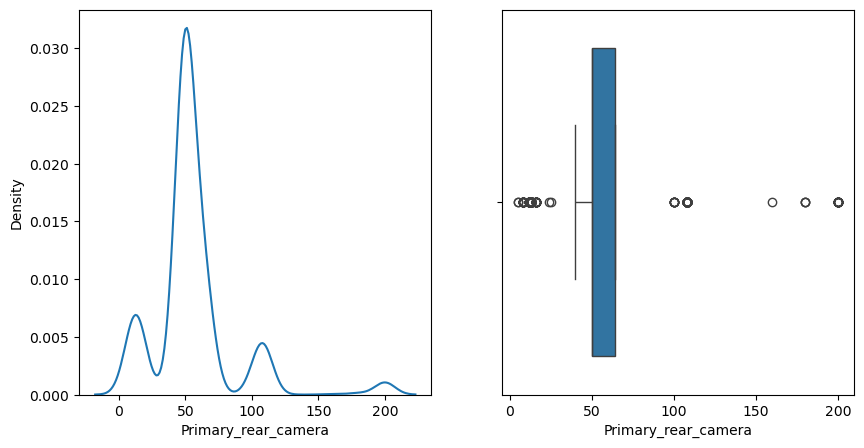

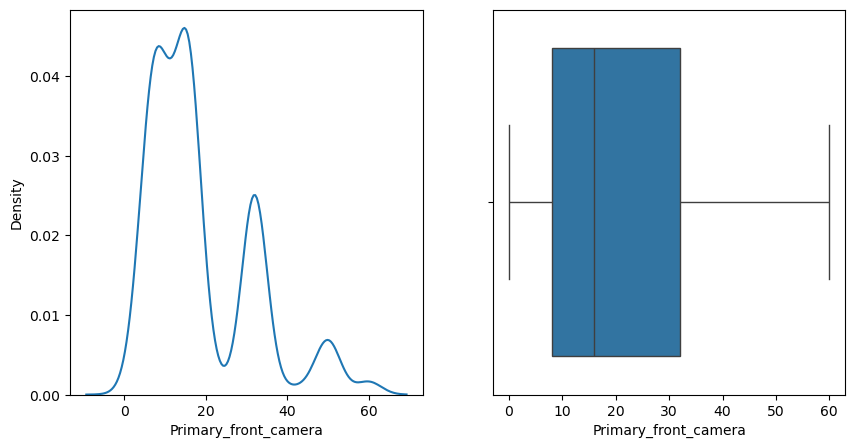

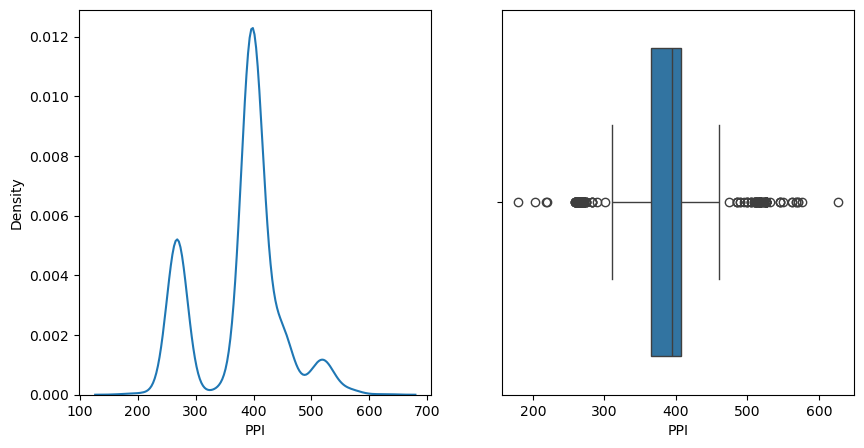

'\nSpec score rigth skewness\nprice and fast charging lift skewness\n'

In [308]:
for i in n_col:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(df,x=i)
    plt.subplot(1,2,2)
    sns.boxplot(df,x=i)
    plt.show()

"""
Spec score rigth skewness
price and fast charging lift skewness
"""

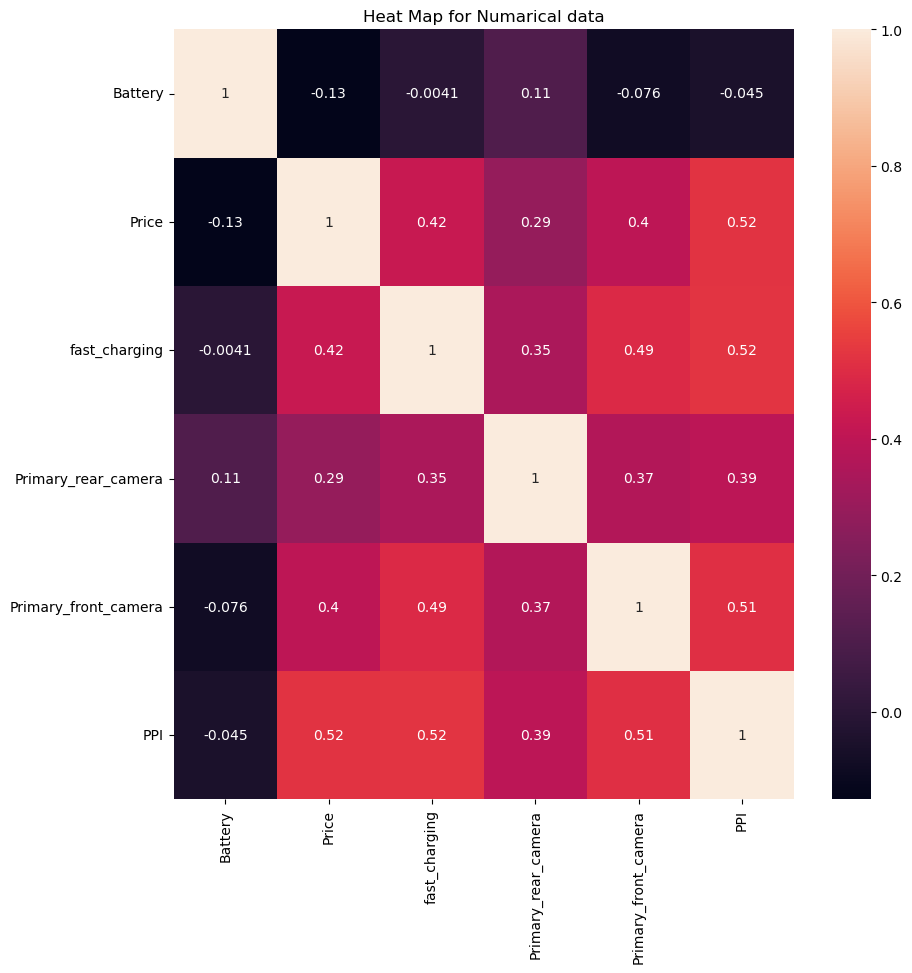

In [309]:
plt.figure(figsize=(10,10))
sns.heatmap(df[n_col].corr(),annot=True)
plt.title("Heat Map for Numarical data")
plt.show()


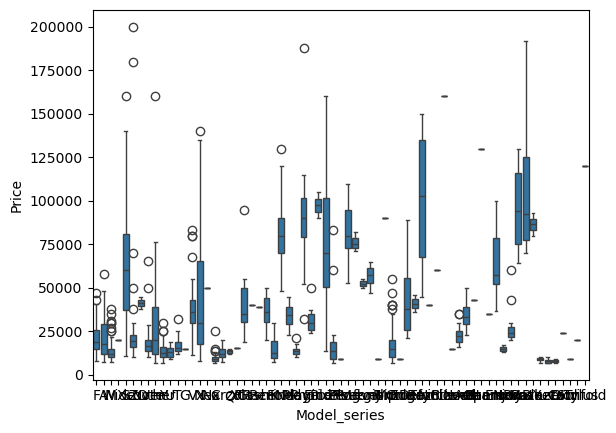

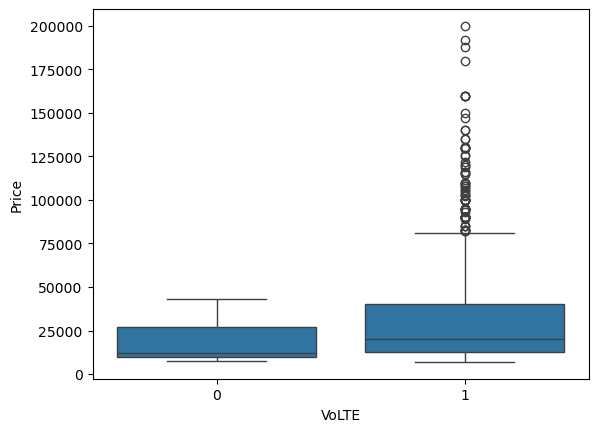

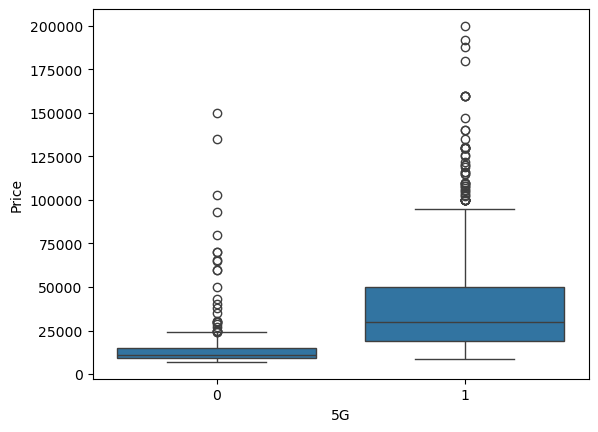

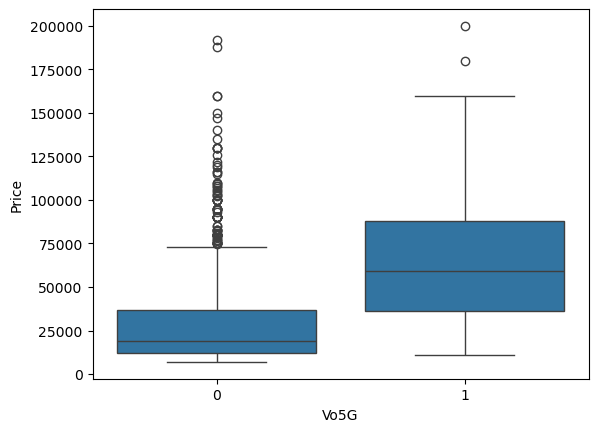

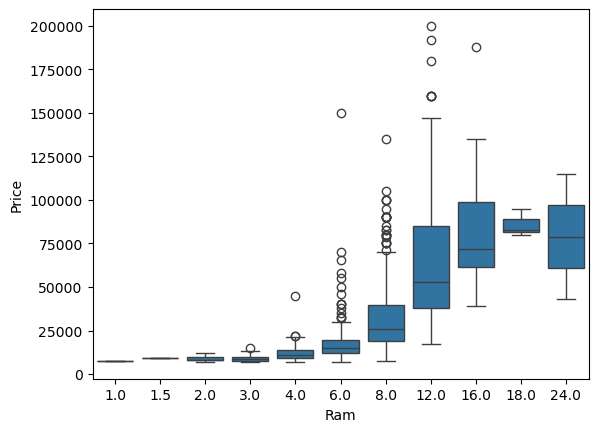

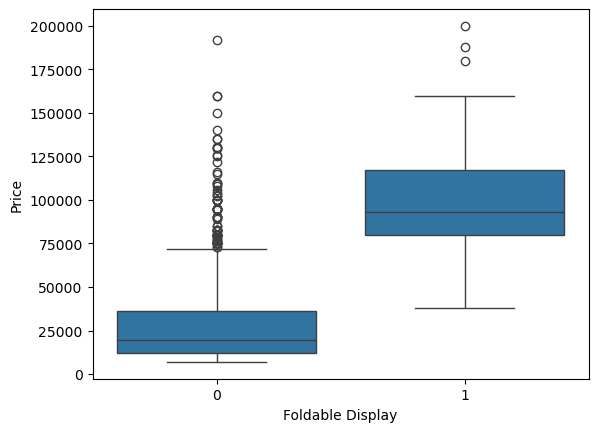

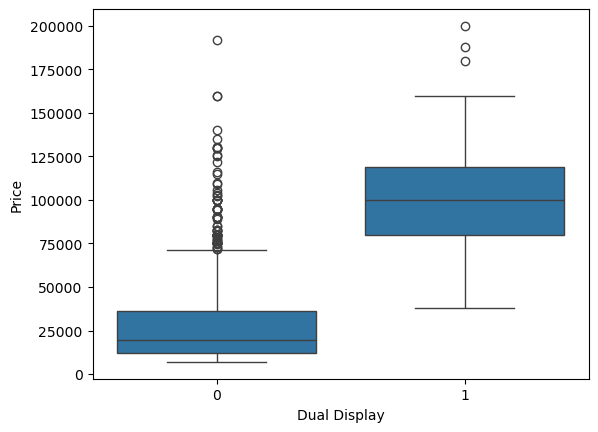

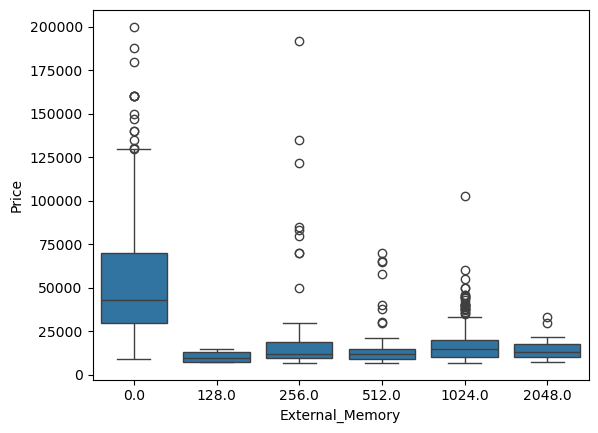

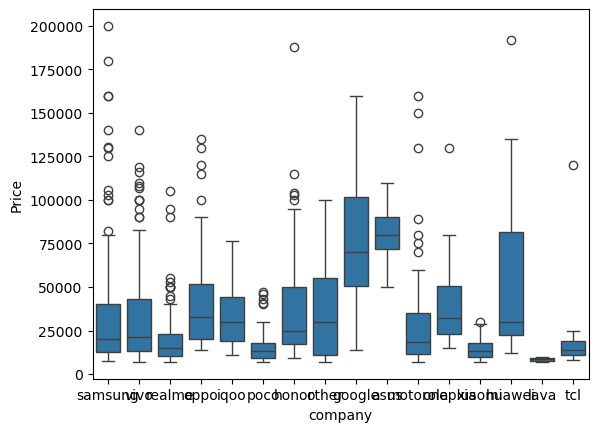

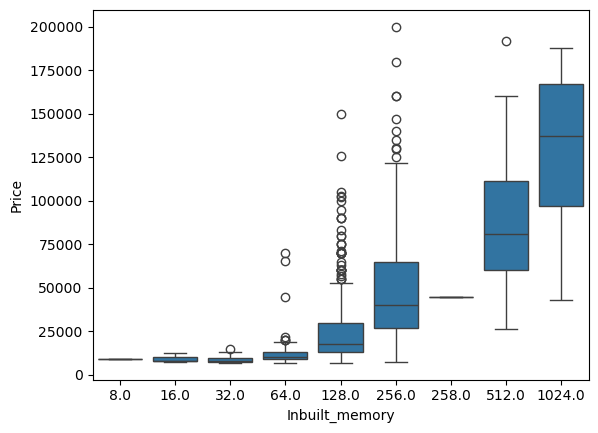

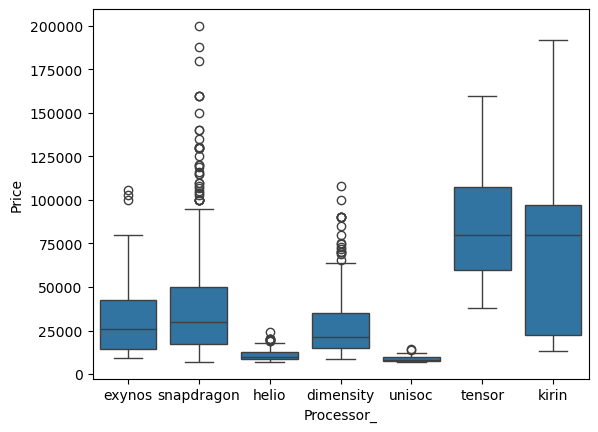

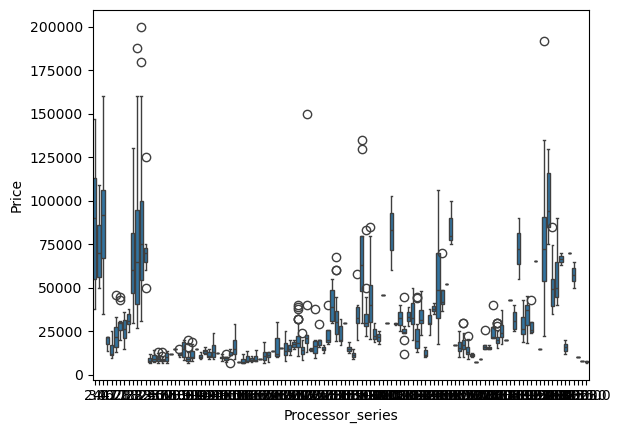

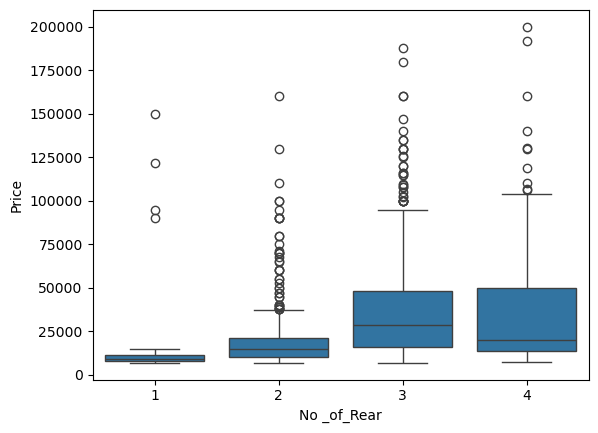

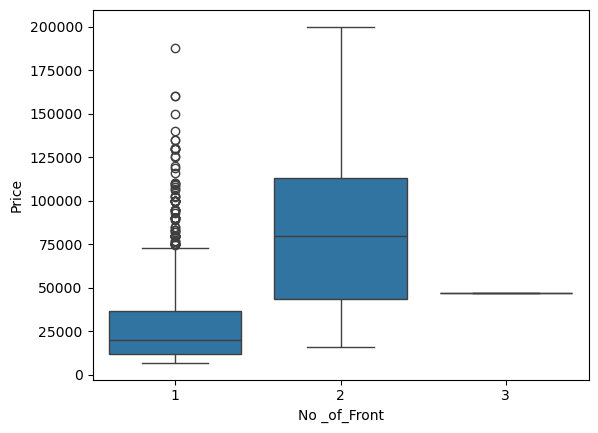

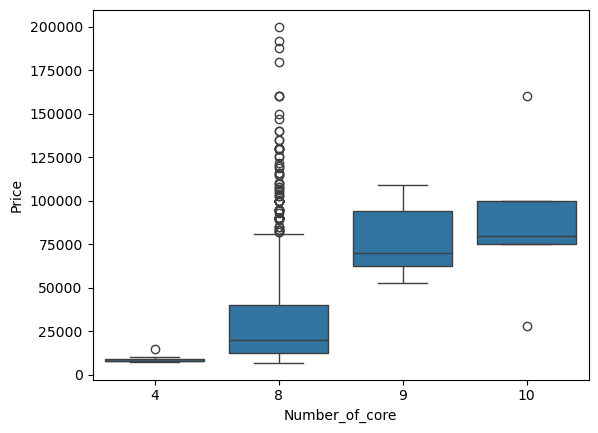

In [310]:
for i in col:
    sns.boxplot(df,y='Price',x=i)
    plt.show()

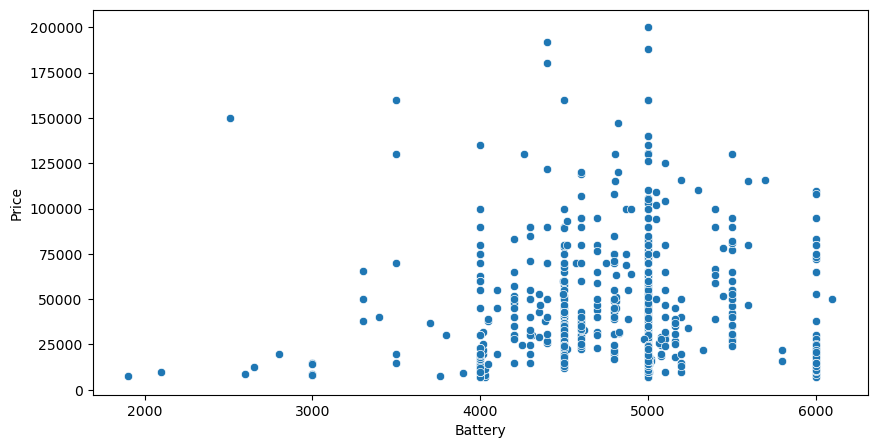

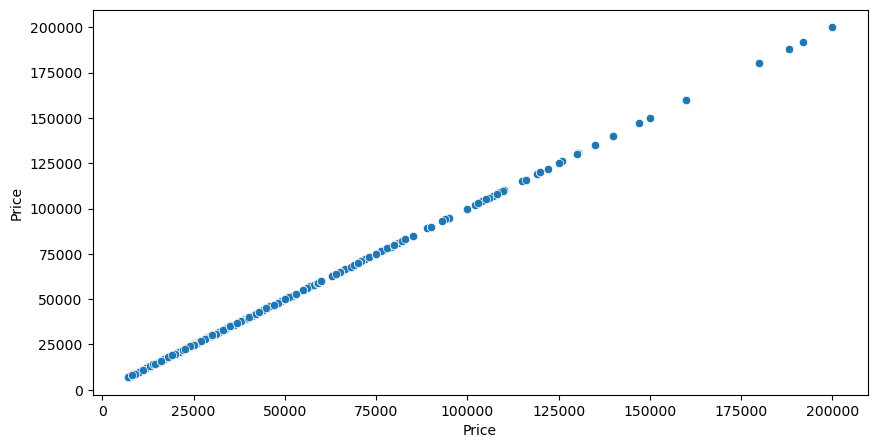

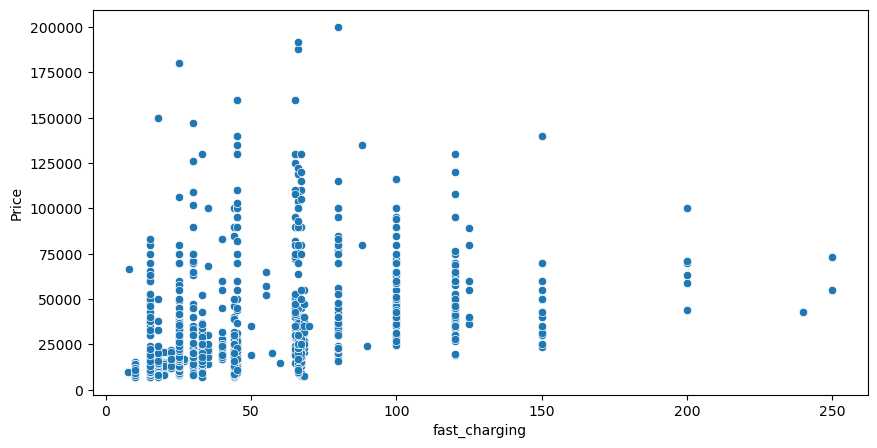

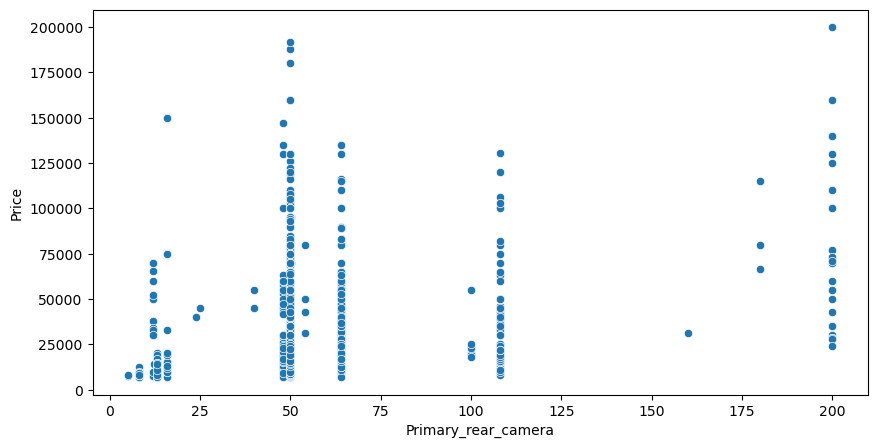

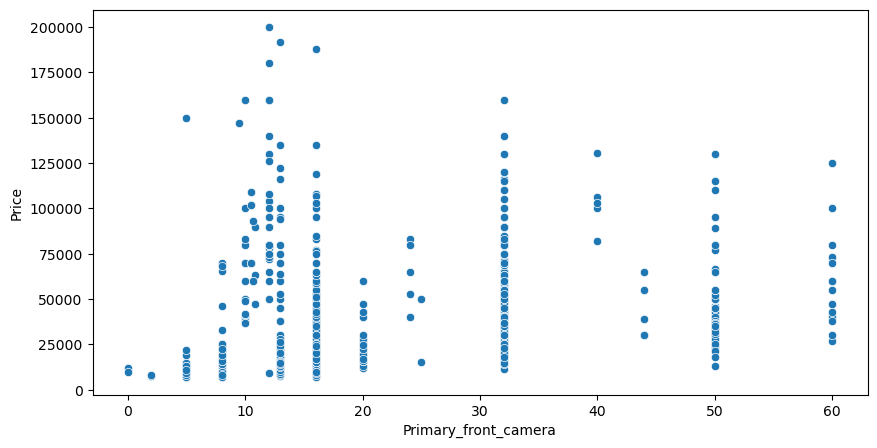

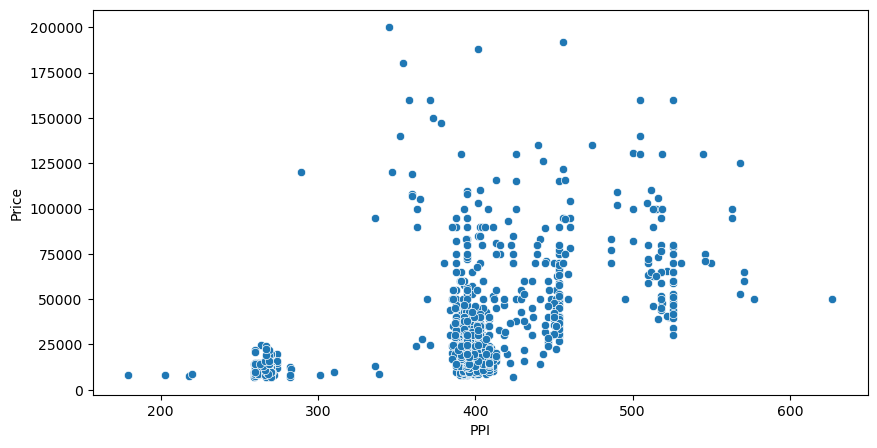

In [311]:
for i in n_col:
    plt.figure(figsize=(10,5))
    sns.scatterplot(df,x=i,y="Price")
    plt.show()


In [401]:

def func(x,y):
    if x=='snapdragon':
        if y < 10:
            return round(round(y)*115+(y-round(y))*500)
        elif y>4000:
            return(y/9)
        else :
            return y
    else:
        return y
    '''if x=='exynos':
        if y > 4000:
            return round(y/10)
        else :
            return y
    elif x=='dimensity':
        if y > 6000:
            return round(y/6.5)
        else :
            return y'''
    
    '''elif x=='kirin':
        if y > 6000:
            return round(y/5)
        else :
            return y
    elif x=='tensor':
        if y < 10:
            return round(800+y*300)
        else :
            return y
    elif y > 6000:
            return round(y/9)'''
    
df['Processor_series']=df[['Processor_','Processor_series']].apply(lambda row: func(row['Processor_'],row['Processor_series']),axis=1)

In [19]:
df.Processor_.unique()

array(['exynos', 'snapdragon', 'helio', 'dimensity', 'unisoc', 'tensor',
       'kirin'], dtype=object)

In [423]:
df.drop([641,394,1052,1027],inplace=True)

In [42]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.compose import TransformedTargetRegressor
import pickle

In [491]:
x=df.drop('Price',axis=1)
y=np.log(df['Price'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=41)

In [443]:
class SparseToDenseTransformer():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()

In [444]:
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                     ('model',OneHotEncoder(drop='first',handle_unknown='ignore'),['Model_series'])],remainder='passthrough',)
poly=ColumnTransformer([('poly', PolynomialFeatures(degree=2),slice(-1))])
box=ColumnTransformer([('box cox',PowerTransformer(standardize=True),slice(-1)),
                      ])
STDT=SparseToDenseTransformer()

In [451]:
lr=LinearRegression()
ll=Lasso(alpha=0.0035)
rl=Ridge(alpha=255,fit_intercept=True)

In [492]:
pipe=Pipeline([('tranformetion',ct),('stdt',STDT),('poly',poly),('box',box),('regressor', TransformedTargetRegressor(
        regressor=ll,
        transformer=StandardScaler()
    ))])
model=pipe.fit(x_train,y_train)

In [493]:
model.score(x_train,y_train)

0.9481262202781027

In [494]:
model.score(x_test,y_test)

0.8858589290791762

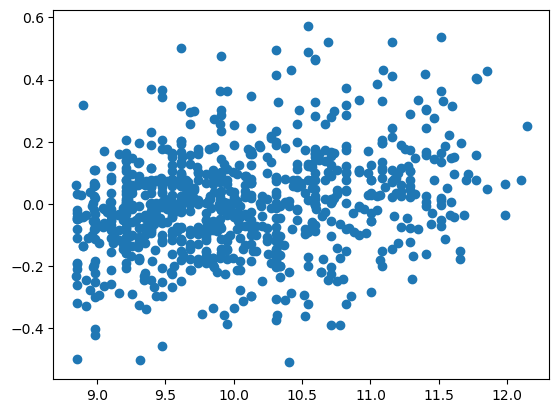

In [487]:
y_pred=model.predict(x_train)
res=y_train-y_pred
plt.scatter(y_train,res)

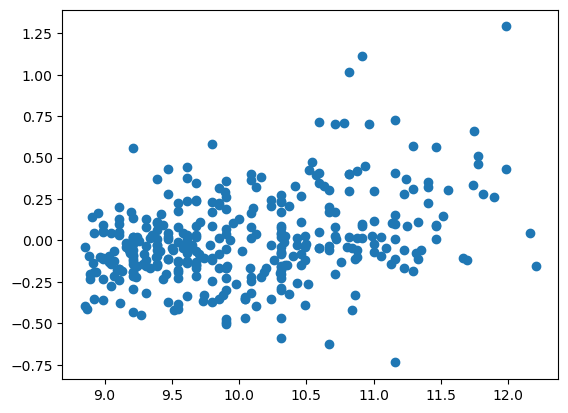

In [488]:
y_pred=model.predict(x_test)
res=y_test-y_pred
plt.scatter(y_test,res)

In [495]:
scores = cross_val_score(pipe,cv=5,X=x_train,y=y_train)
scores.mean()

0.8993251805169088

In [225]:
cv=GridSearchCV(estimator=Lasso(),cv=5,param_grid={'alpha':[.002,.0025,.003],'fit_intercept':[True,False]},n_jobs=-1)

In [226]:
cv.fit(t,y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.002, 0.0025, 0.003],
                         'fit_intercept': [True, False]})

In [227]:
cv.best_params_

{'alpha': 0.003, 'fit_intercept': True}

In [490]:
with open('smart_phone_price_Lasso.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('df.pkl', 'wb') as file:
    pickle.dump(df, file)


Random forest

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [496]:
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                      ('model',OneHotEncoder(drop='first',handle_unknown='ignore'),['Model_series'])],remainder='passthrough')

In [497]:
x=df.drop('Price',axis=1)
y=np.log(df['Price'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=40)

In [498]:
rf=RandomForestRegressor(n_estimators=1300,min_samples_split=3,max_features=0.7,n_jobs=-1)

In [499]:
pipe=Pipeline([('tranformetion',ct),('stdt',STDT),('resression',rf)])
model=pipe.fit(x_train,y_train)

In [500]:
model.score(x_train,y_train)

0.9852683530241856

In [501]:
model.score(x_test,y_test)

0.9038881938391545

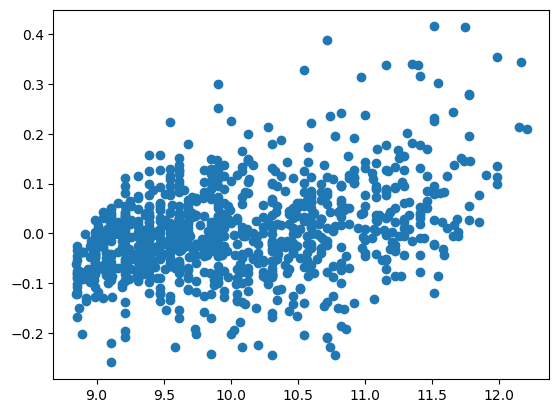

In [502]:
y_pred=model.predict(x_train)
res=y_train-y_pred
plt.scatter(y=res,x=y_train)

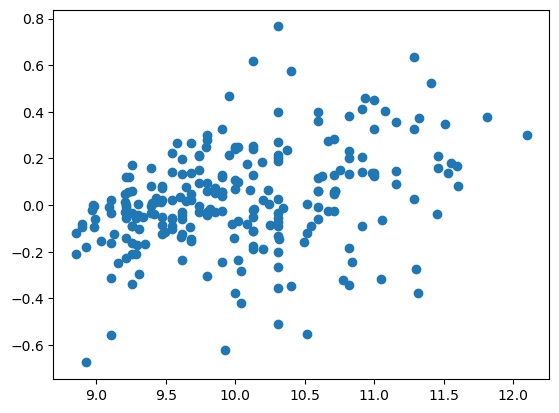

In [503]:
y_pred=model.predict(x_test)
res=y_test-y_pred
plt.scatter(y_test,res)

In [504]:
scores = cross_val_score(pipe,cv=5,X=x_train,y=y_train)

In [505]:
scores.mean()

0.901851425888818

In [506]:
with open('smart_phone_price_with_RFR.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('df.pkl', 'wb') as file:
    pickle.dump(df, file)

ann

In [ ]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import Sequential
from keras.layers import Dense
from keras.metrics import R2Score

In [ ]:
x=df.drop('Price',axis=1)
y=df['Price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x_train.columns.difference(['company', 'Processor_'])

In [ ]:
numerical_columns = x_train.columns.difference(['company', 'Processor_'])
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                      ('model',OneHotEncoder(drop='first',handle_unknown='ignore'),['Model_series'])],remainder='passthrough')
std=StandardScaler()
pipe=Pipeline([('1',ct),('stdt',STDT),('3',std)])
x_train=pipe.fit_transform(x_train)
x_test=pipe.transform(x_test)

In [ ]:
x_train.shape

In [ ]:
model=Sequential()
model.add(Dense(97,activation='relu',input_dim=97))
model.add(Dense(97,activation='relu'))
model.add(Dense(97,activation='relu'))
model.add(Dense(97,activation='relu'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='mse',optimizer='adam')

In [ ]:
model.fit(x_train,y_train,epochs=90,validation_data=(x_test,y_test))

In [ ]:
ypr=model.predict(x_train)
r2_score(y_train,ypr[:,0])

In [ ]:
ypr=model.predict(x_test)
r2_score(y_test,ypr[:,0])

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
x={
        'Dual Sim':[1],'VoLTE':[1],'5G': [1],
        'Vo5G':[1],'Ram':[8],'Battery':[4500],'Foldable Display':[0],
        'company':['google'],'Inbuilt_memory':[128],'fast_charging':[25],
        'Dual Display':[1],'External_Memory':[1024],
        'Water Drop Notch':[1],'with Punch Hole':[0],
        'Processor_':['snapdragon'],'Processor_series':[888],'No _of_Rear':3,'No _of_Front':[1],
        'Primary_rear_camera':[64],'Primary_front_camera':[32],
        'Number_of_core':[8],
        'PPI':[399],
    }
x=pd.DataFrame(x)
x